In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('dataResearch.csv', index_col=0 ,usecols=lambda column: column not in ['SL.', 'Station','Year','Month','Temperature (maximum)','Temperature(Average)','Rainfall(mm)','Humidity(percentage)'])
df

,Temperature(minimum)
Date,
1/1/1970,11.37
1/2/1970,14.07
1/3/1970,17.86
1/4/1970,21.65
1/5/1970,23.08
...,...
1/8/2022,26.20
1/9/2022,25.57
1/10/2022,23.47


In [3]:
df.tail()

,Temperature(minimum)
Date,
1/8/2022,26.20
1/9/2022,25.57
1/10/2022,23.47
1/11/2022,19.55
1/12/2022,16.57


In [3]:
# Extract the 'Temperature(minimum)' column
temperature_data = df['Temperature(minimum)'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
temperature_scaled = scaler.fit_transform(temperature_data)

# Prepare the data for training
sequence_length = 24  # Adjust this based on your preference and the periodicity of the data
X, y = [], []
for i in range(len(temperature_scaled) - sequence_length):
    X.append(temperature_scaled[i:i + sequence_length])
    y.append(temperature_scaled[i + sequence_length])

X = np.array(X)
y = np.array(y)

In [4]:
# Split the data into training and validation sets
split_index = int(len(X) * 0.8)  # 80% training, 20% validation
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [5]:

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()


In [6]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


In [7]:
# Instantiate the model, loss function, and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Train the model
epochs = 100
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f'Epoch {i} Loss: {single_loss.item()}')

Epoch 0 Loss: 0.004957922268658876
Epoch 10 Loss: 0.0005846231360919774
Epoch 20 Loss: 0.001100738300010562
Epoch 30 Loss: 0.0011221831664443016
Epoch 40 Loss: 0.0009940671734511852
Epoch 50 Loss: 0.0008840265800245106
Epoch 60 Loss: 0.0007911691791377962
Epoch 70 Loss: 0.0006938776350580156
Epoch 80 Loss: 0.0005716503947041929
Epoch 90 Loss: 0.0007653862703591585


In [9]:
# Evaluate the model on the validation set
model.eval()
y_pred = []
for seq in X_val:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        pred_value = model(seq).item()
        y_pred.append(pred_value)
        print(f'Predicted Value: {pred_value}')

Predicted Value: 0.8146873712539673
Predicted Value: 0.5106667280197144
Predicted Value: 0.2597771883010864
Predicted Value: 0.15177349746227264
Predicted Value: 0.29229921102523804
Predicted Value: 0.5681598782539368
Predicted Value: 0.7276204824447632
Predicted Value: 0.8153663277626038
Predicted Value: 0.9022900462150574
Predicted Value: 0.9585051536560059
Predicted Value: 0.9637327790260315
Predicted Value: 0.9310601353645325
Predicted Value: 0.8018500208854675
Predicted Value: 0.5033354759216309
Predicted Value: 0.2154817134141922
Predicted Value: 0.18234845995903015
Predicted Value: 0.31974124908447266
Predicted Value: 0.5636028051376343
Predicted Value: 0.6540347337722778
Predicted Value: 0.8408675789833069
Predicted Value: 0.910179615020752
Predicted Value: 0.9596555233001709
Predicted Value: 0.9614616632461548
Predicted Value: 0.9138668775558472
Predicted Value: 0.7686499357223511
Predicted Value: 0.49237149953842163
Predicted Value: 0.24803514778614044
Predicted Value: 0.1809

In [10]:
# Inverse transform the predicted values
y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Inverse transform the actual values
y_val_inv = scaler.inverse_transform(y_val.numpy().reshape(-1, 1))


In [11]:
# Print the predicted values
print("\nPredicted Minimum Temperatures:")
for i in range(len(y_pred)):
    print(f'Index {split_index + i}: {y_pred[i][0]:.2f}')



Predicted Minimum Temperatures:
Index 489: 23.51
Index 490: 18.68
Index 491: 14.70
Index 492: 12.99
Index 493: 15.22
Index 494: 19.60
Index 495: 22.13
Index 496: 23.52
Index 497: 24.90
Index 498: 25.79
Index 499: 25.87
Index 500: 25.36
Index 501: 23.31
Index 502: 18.57
Index 503: 14.00
Index 504: 13.47
Index 505: 15.65
Index 506: 19.52
Index 507: 20.96
Index 508: 23.92
Index 509: 25.02
Index 510: 25.81
Index 511: 25.84
Index 512: 25.08
Index 513: 22.78
Index 514: 18.39
Index 515: 14.52
Index 516: 13.45
Index 517: 16.52
Index 518: 19.60
Index 519: 21.40
Index 520: 23.55
Index 521: 24.68
Index 522: 25.63
Index 523: 25.81
Index 524: 25.27
Index 525: 23.27
Index 526: 18.77
Index 527: 14.70
Index 528: 13.19
Index 529: 15.71
Index 530: 20.33
Index 531: 22.15
Index 532: 23.57
Index 533: 24.86
Index 534: 25.71
Index 535: 25.80
Index 536: 25.52
Index 537: 23.43
Index 538: 19.24
Index 539: 14.92
Index 540: 13.69
Index 541: 15.39
Index 542: 19.58
Index 543: 21.06
Index 544: 23.30
Index 545: 24.7

In [12]:
# Evaluate the model
mse = mean_squared_error(y_val_inv, y_pred)
print(f'\nMean Squared Error on Validation Set: {mse}')


Mean Squared Error on Validation Set: 0.5069500114213508


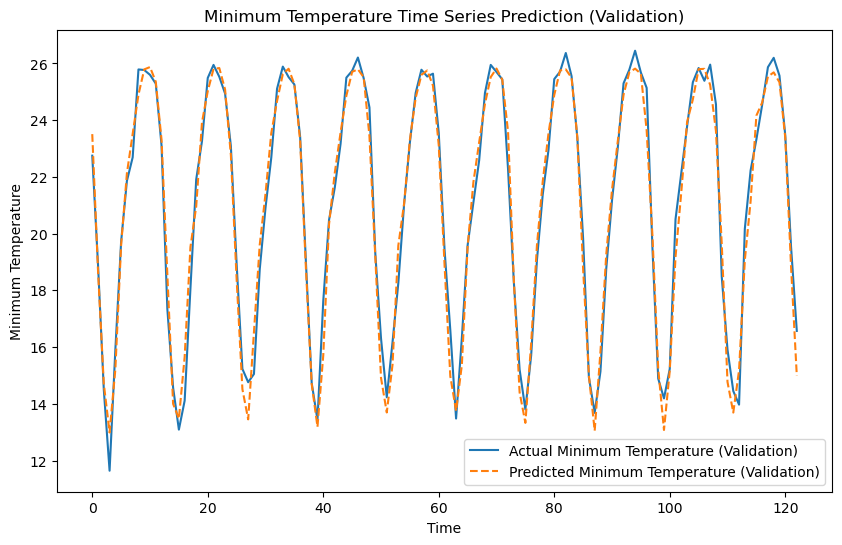

In [13]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Minimum Temperature (Validation)')
plt.plot(y_pred, label='Predicted Minimum Temperature (Validation)', linestyle='--')
plt.title('Minimum Temperature Time Series Prediction (Validation)')
plt.xlabel('Time')
plt.ylabel('Minimum Temperature')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate the model on the validation set
model.eval()
y_pred = []
for seq in X_val:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        y_pred.append(model(seq).item())

# Inverse transform the predicted values
y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Calculate and print R2 value
r2 = r2_score(y_val_inv, y_pred)
print(f'R-squared (R2) on Validation Set: {r2}')


R-squared (R2) on Validation Set: 0.972534259129317


## This upper portion code is perfect as its shows 97% accuracy ..But problem is to finding predicted data as below

In [22]:
# Assuming your LSTM model is defined like this
class LSTM(nn.Module):
    def __init__(self, input_size=24, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [23]:
model.eval()
input_size = 12  # Replace 10 with the actual number of features in your input data


with torch.no_grad():
    # Initialize future sequence with the last sequence_length values from the training data
    future_seq = X_train[-sequence_length:].tolist()

    predictions_2023 = []
    for _ in range(12):  # Assuming you want predictions for 12 months
        future_seq_tensor = torch.FloatTensor(np.array(future_seq).reshape(1, sequence_length, input_size))
        
        # Reinitialize the hidden state for each prediction
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        
        # Forward pass to get the prediction
        predictions_2023.append(model(future_seq_tensor).item())
        
        # Append the prediction to the future sequence for the next iteration
        future_seq.append(predictions_2023[-1])

# Inverse transform the predicted values
predictions_2023 = scaler.inverse_transform(np.array(predictions_2023).reshape(-1, 1))

# Create a DataFrame with dates and the predicted values for 2023
index_2023 = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=len(predictions_2023), freq='M')
df_predictions_2023 = pd.DataFrame(data={'Temperature(minimum)': predictions_2023.flatten()}, index=index_2023)


ValueError: cannot reshape array of size 576 into shape (1,24,12)

In [ ]:
# Generate predictions for the year 2023
model.eval()
with torch.no_grad():
    # Use the last sequence in the training data to start the prediction
    future_seq = X_train[-1].tolist()

    predictions_2023 = []
    for _ in range(12):  # Assuming you want predictions for 12 months
        future_seq_tensor = torch.FloatTensor(np.array(future_seq[-sequence_length:]).reshape(1, -1, 24))
        with torch.no_grad():
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))
            predictions_2023.append(model(future_seq_tensor).item())
            future_seq.append(predictions_2023[-1])

# Inverse transform the predicted values
predictions_2023 = scaler.inverse_transform(np.array(predictions_2023).reshape(-1, 1))

# Create a DataFrame with dates and the predicted values for 2023
index_2023 = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=len(predictions_2023), freq='M')
df_predictions_2023 = pd.DataFrame(data={'Temperature(minimum)': predictions_2023.flatten()}, index=index_2023)

# Print the DataFrame with the predicted values for 2023
print("\nDataFrame with Predicted Minimum Temperatures for 2023:")
print(df_predictions_2023)

